## setup

In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

#import packages
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import subprocess
from datetime import datetime


#local imports from opensoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.ribbit import ribbit

# create big visuals
plt.rcParams['figure.figsize']=[15,8]
pd.set_option('display.precision', 2)

## read in RIBBIT scores and basic cleaning 

In [2]:
def read_ribbit_scores(ribbit_folder):  

    #creates list of all csv ribbit files to concatonate into one df of all ribbit scores
    all_files = glob(ribbit_folder + "/*.csv")
    ribbit_list = []

    # reads in all ribbit scores to csv 
    for filename in all_files: 
        df = pd.read_csv("./" + filename)
        ribbit_list.append(df)

    rs_df = pd.DataFrame()
    rs_df = pd.concat(ribbit_list, axis=0, ignore_index=True) # translates list into dataframe 

    rs_df = rs_df.rename(columns={"Unnamed: 0" : "file_path"})
    
    # use file_path to create column with date and time of file 
    rs_df['date'] = pd.to_datetime(rs_df.file_path.str[-19:-4], format='%Y%m%d_%H%M%S', errors='coerce')

    return rs_df
    
# read ribbit scores for FLSH
rs_df = read_ribbit_scores("ribbit_scores_2022_01_21")


# add in manually determined files (files people listened to and recorded what frogs were heard)
tr_df = pd.read_csv("./training_data.csv")
rs_df = pd.merge(rs_df, tr_df, on=['pond', 'file_path'], how = "left")
rs_df = rs_df.drop_duplicates() # TODO: remove duplicates #TODO: why duplicates? file with all scores? 

# todo: add that if file starts with "Lcapito", Lcapito = 1


# read ribbit scores for ichaway
ich_df = read_ribbit_scores("ribbit_scores_ichaway")
ich_verified_df = pd.read_csv("./ichaway_verified_data_2015.csv")

## create dataframe with Lcapito presence/abscence for each file 
# create column with unique file path for each audio file (there are multiple rows for some files - one for each frog observed in that file)
ich_verified_df['file_path']='/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/ichaway_2015/' + ich_verified_df['Logger'].astype('string') + 'a/' + ich_verified_df['File ID'] + '.wav'
# add column with 1/0 for if the observation is of a Lcapito
ich_verified_df['Lcapito'] = ich_verified_df['Species'] == 'LICAP'
ich_verified_df['Lcapito'] = ich_verified_df['Lcapito'].astype('int')
# group one row per audio file with 1/0 for presence/abscence fo Lcapito
ich_tr_df = ich_verified_df.groupby('file_path').agg(Lcapito = ('Lcapito', 'max'))

ich_df = pd.merge(ich_df, ich_tr_df, on=['file_path'], how = "left")
ich_df = ich_df.drop_duplicates() # remove duplicates #TODO: why duplicates? file with all scores? 

# make dataframe with only files that have been maunally verified 
ich_tr_df = ich_df.dropna()


In [ ]:
## Read in verified files - right now this is with signal band [300-1000], noise band [150,200][1200,1600], clip duration = 1.5 s
ich_verified_files_df = pd.read_csv("./ribbit_scores_ichaway_verified_files/ichaway_verified_files_ribbit_scores.csv")
ich_verified_files_df['date']=pd.to_datetime(ich_verified_files_df['date'])


# read in SA files
sa_pulse_df = pd.read_csv("./ribbit_scores_pulse_rate_range/ribbit_scores2.csv")
sa_pulse_df['date']=pd.to_datetime(sa_pulse_df['date'])



In [3]:
print("Number of verified files in Ichaway data: " + str(len(ich_tr_df)))
print("Number of gopher frog observations in verified data: " + str(len(ich_tr_df[ich_tr_df['Lcapito'] == 1])))

# save list of the files that have been listened to at ichaway
#temp = ich_tr_df.drop(columns = ['score', 'time_stamp'])
#temp.to_csv('ich_verified_files.csv')

Number of verified files in Ichaway data: 2564
Number of gopher frog observations in verified data: 53


## Functions

In [ ]:
def plot_rs(plot_df, score_col = 'score', cutoff = -1):
    plot_df1 = plot_df[plot_df['Lcapito'] == 1]
    plot_df0 = plot_df[plot_df['Lcapito'] == 0]

    fig, ax = plt.subplots()  # a figure with a single Axes
    ax.scatter(plot_df0['date'],plot_df0[score_col], alpha = 0.5)
    ax.scatter(plot_df1['date'],plot_df1[score_col], alpha = 0.5)
    #plt.ylim(0, 100)
    if cutoff > 0: 
        ax.hlines(y = [cutoff], xmin = plot_df.date.min(), 
                    xmax = plot_df.date.max(),
                    colors = 'r', linestyles = '--')
    ax.set_xlabel('date')
    ax.set_ylabel('RIBBIT score') 
    ax.set_title('RIBBIT scores')

## Look at what files we got wrong

In [185]:
# Look at files with lowest RIBBIT scores that have documented Lcapito 
ich_tr_df[ich_tr_df['Lcapito'] == 1].sort_values(by = "score", ascending = True) 

#look at files with high RIBBIT scores with no documented Lcapito
ich_tr_df[ich_tr_df['Lcapito'] == 0].sort_values(by = "score", ascending = False).head(10) 


# List all false negatives in df
#df = ich_verified_files_df
df = ich_tr_df
false_neg = df[(df['Lcapito'] == 1) & (df['score']<100)].sort_values(by = ["pond", "date"], ascending = True) 

print("Number of false negatives: " + str(len(false_neg)))
false_neg

number of false negatives29


,file_path,score,year,pond,time_stamp,date,Lcapito
2734,/Volumes/Expansion/Frog Call Project/Calling D...,14.47,2015,10a,37.0,2015-03-14 20:15:00,1.0
2687,/Volumes/Expansion/Frog Call Project/Calling D...,18.20,2015,10a,53.0,2015-03-14 23:15:00,1.0
1423,/Volumes/Expansion/Frog Call Project/Calling D...,87.21,2015,2a,205.0,2015-02-02 22:44:00,1.0
1465,/Volumes/Expansion/Frog Call Project/Calling D...,48.92,2015,2a,291.0,2015-02-04 19:46:00,1.0
1544,/Volumes/Expansion/Frog Call Project/Calling D...,35.16,2015,2a,3.0,2015-02-04 20:46:00,1.0
1728,/Volumes/Expansion/Frog Call Project/Calling D...,8.14,2015,2a,7.0,2015-02-05 18:47:00,1.0
1435,/Volumes/Expansion/Frog Call Project/Calling D...,61.56,2015,2a,24.0,2015-02-05 19:47:00,1.0
1224,/Volumes/Expansion/Frog Call Project/Calling D...,31.18,2015,4a,256.0,2015-02-24 19:02:00,1.0
1298,/Volumes/Expansion/Frog Call Project/Calling D...,18.44,2015,4a,5.0,2015-02-25 19:03:00,1.0
4619,/Volumes/Expansion/Frog Call Project/Calling D...,83.00,2015,5a,277.0,2015-02-03 20:45:00,1.0


## Pulse rate SA 

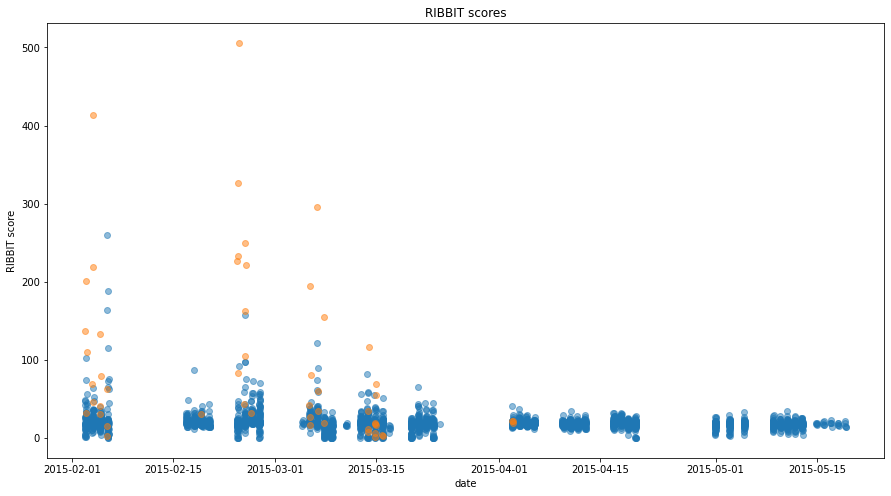

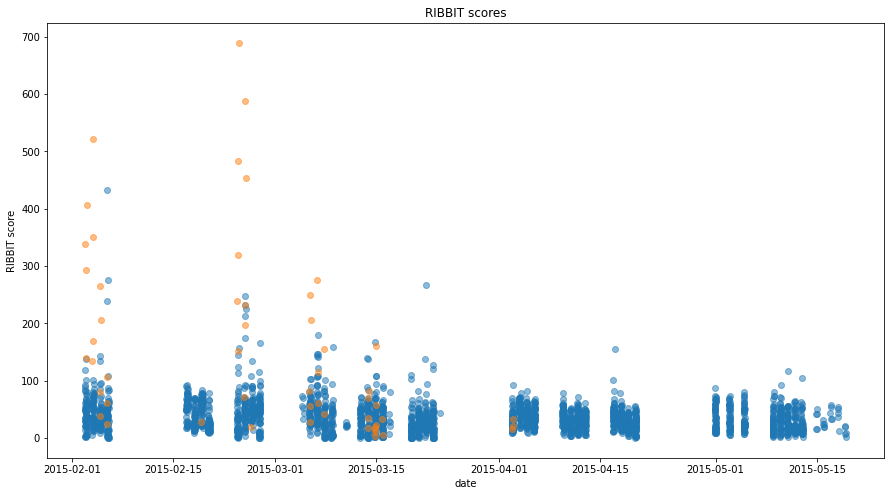

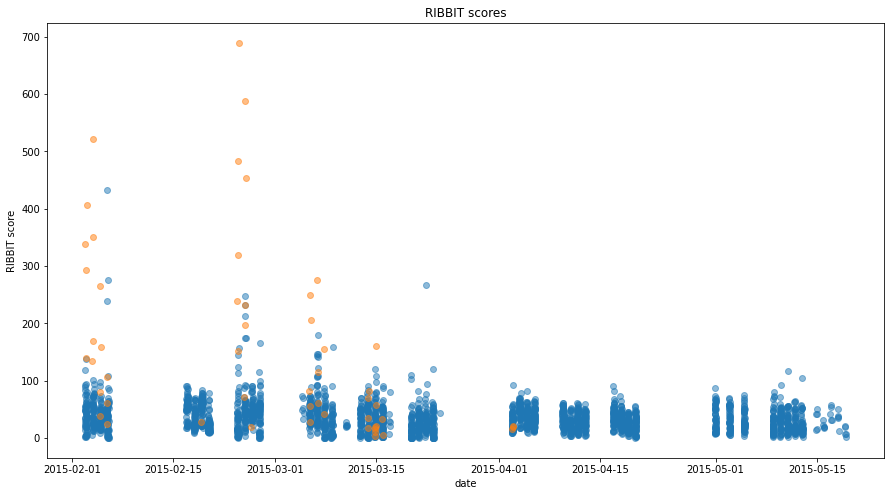

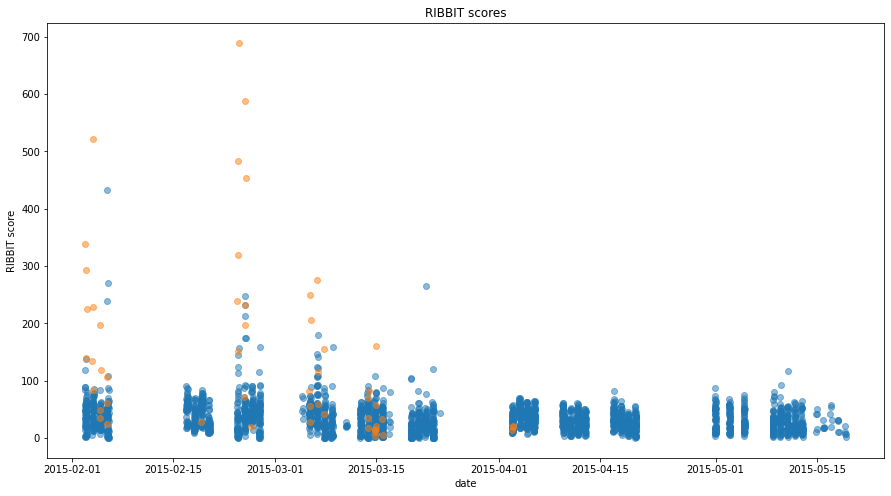

In [186]:
# plot ribbit scores for pulse rate SA 

#plot_rs(ich_verified_files_df)
plot_rs(sa_pulse_df, score_col = 'score0')
plot_rs(sa_pulse_df, score_col = 'score1')
plot_rs(sa_pulse_df, score_col = 'score2')



In [181]:
## Plotting precision vs recall 

# precision/recall
cutoffs = range(0,200)


def calc_accuracy(df, cutoffs):    
    accuracy = pd.DataFrame()
    accuracy.index = list(cutoffs)
    accuracy['precision'] = ''
    accuracy['recall'] = ''

    for c in cutoffs: 
        accuracy['precision'][c] = len(df[(df['Lcapito']==1) & (df['score']>c)])/len(df[df['score']>c])*100
        accuracy['recall'][c] = len(df[(df['Lcapito'] == 1) & (df['score']>c)])/len(df[(df['Lcapito'] == 1)])*100

    return accuracy

sa_pulse_df['score'] = sa_pulse_df['score0'] 
ich_accuracy0 = calc_accuracy(sa_pulse_df, cutoffs)
#ich_accuracy0 = calc_accuracy(sa_pulse_df[sa_pulse_df["pond"]!="7a"], cutoffs)
sa_pulse_df['score'] = sa_pulse_df['score1'] 
ich_accuracy1 = calc_accuracy(sa_pulse_df, cutoffs)
#ich_accuracy0 = calc_accuracy(sa_pulse_df[sa_pulse_df["pond"]!="7a"], cutoffs)
sa_pulse_df['score'] = sa_pulse_df['score2'] 
ich_accuracy2 = calc_accuracy(sa_pulse_df, cutoffs)
#ich_accuracy0 = calc_accuracy(sa_pulse_df[sa_pulse_df["pond"]!="7a"], cutoffs)




Text(0, 0.5, 'recall')

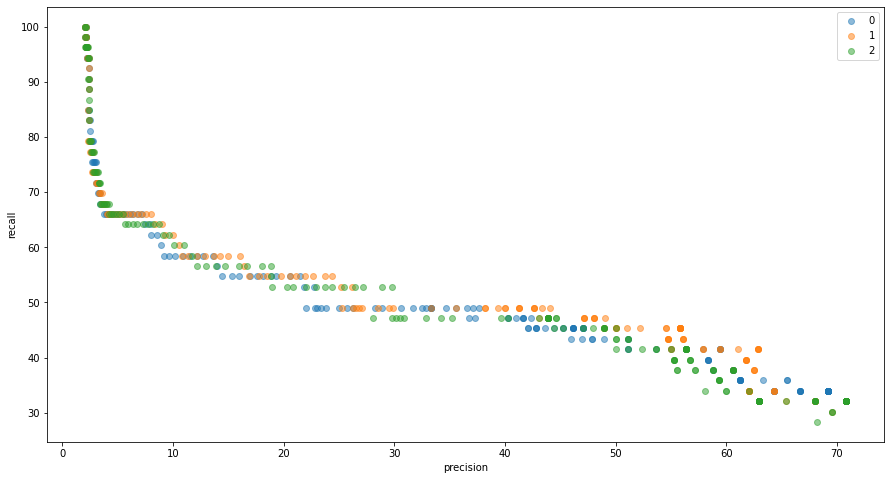

In [182]:
# plot precision and recall for pulse rate sa - looks like [12,28] is best of the options 

fig, ax = plt.subplots()  # a figure with a single Axes
ax.scatter(ich_accuracy0['precision'],ich_accuracy0['recall'], alpha = 0.5, label = "0")
ax.scatter(ich_accuracy1['precision'],ich_accuracy1['recall'], alpha = 0.5, label = "1") # best
ax.scatter(ich_accuracy2['precision'],ich_accuracy2['recall'], alpha = 0.5, label = "2")
ax.legend()
ax.set_xlabel('precision')
ax.set_ylabel('recall') 
#ax.set_title('RIBBIT scores')

## Look at individual file to see why model isn't doing well for it 

spectrogram


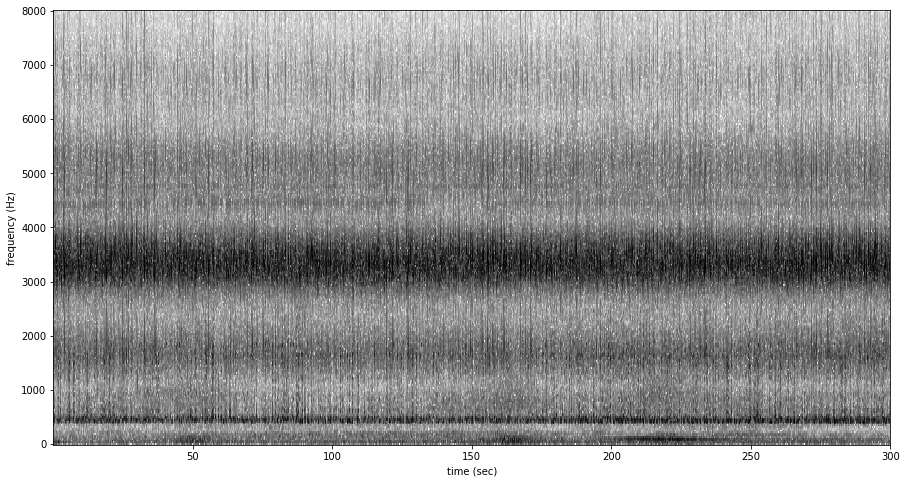

/Users/mayalapp/opt/anaconda3/envs/opensoundscape060/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 62, using nperseg = 62
  .format(nperseg, input_length))
/Users/mayalapp/opt/anaconda3/envs/opensoundscape060/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  .format(nperseg, input_length))


Text(0.5, 1.0, 'RIBBIT scores for 10 second file with Great Plains Toad at the beginning')

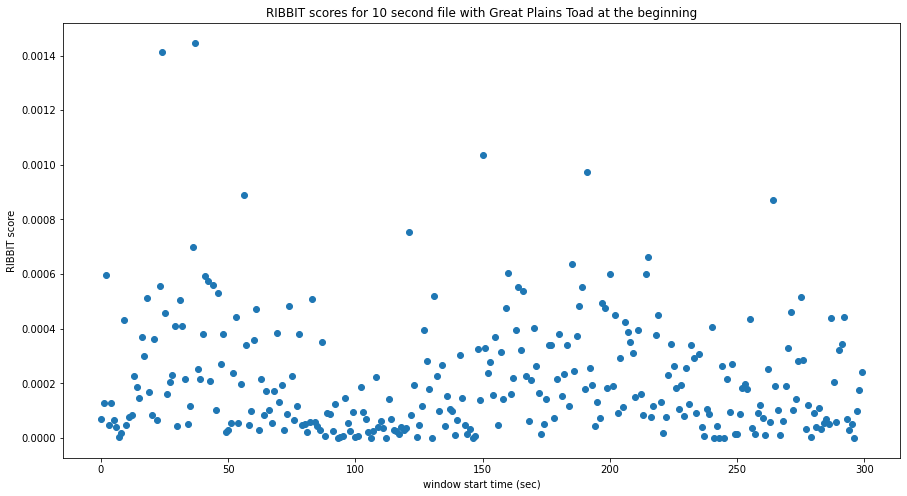

In [15]:
# Look at individual file

#get the audio file path
audio_path = ich_tr_df['file_path'][2734]
audio = Audio.from_file(audio_path)

#make the spectrogram
spec = Spectrogram.from_audio(audio.from_file(audio_path))

#show the spectrogram
print('spectrogram')
spec.plot()

#run RIBBIT
# minimum and maximum rate of pulsing (pulses per second) to search for
pulse_rate_range = [14,28] 

# look for a vocalization in the range of 600-800 Hz
signal_band = [600,800]

# subtract the amplitude signal from these frequency ranges
noise_bands = [[150,200], [1500,1600]]

#divides the signal into segments this many seconds long, analyzes each independently
clip_duration = 1 #seconds
clip_overlap = 0.5 #seconds
score_df =  ribbit(
                    spec,
                    pulse_rate_range=pulse_rate_range,
                    signal_band=signal_band,
                    clip_duration=clip_duration,
                    noise_bands=noise_bands,
                    plot=False
)

# plot the score vs time of each window
plt.scatter(score_df['start_time'],score_df['score'])
plt.xlabel('window start time (sec)')
plt.ylabel('RIBBIT score')
plt.title('RIBBIT scores for 10 second file with Great Plains Toad at the beginning')



In [12]:
ich_tr_df['file_path'][2734]
glob(ich_tr_df['file_path'][2734])

['/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/ichaway_2015/10a/20150314_201500.wav']

## Analyzing FLSHE

In [159]:
def plot_rs_flshe(plot_data = rs_df, pond_no = "all", year = "all"):
    
    if pond_no != "all":
        plot_data = plot_data[plot_data['pond'] == pond_no]

    if year != "all":
        plot_data = plot_data[plot_data['year'] == year]

        
    
    fig, ax = plt.subplots()  # a figure with a single Axes
    ax.scatter(plot_data['date'],plot_data['score'])
    ax.hlines(y = [40], xmin = plot_data.date.min(), 
              xmax = plot_data.date.max(),
             colors = 'r', linestyles = '--')
    ax.set_xlabel('date')
    ax.set_ylabel('RIBBIT score') 
    ax.set_title('RIBBIT scores')
    #ax.set_ylim(0,400)
    
def plot_hist(pond_no = "all", year = "all"):
    
    plot_data = rs_df

    if pond_no != "all":
        plot_data = plot_data[plot_data['pond'] == pond_no]

    if year != "all":
        plot_data = plot_data[plot_data['year'] == year]

        
    
    fig, ax = plt.subplots()  # a figure with a single Axes
    ax.hist(plot_data['date'], bins = 12*12)
    ax.set_xlabel('date')
    ax.set_ylabel('Number of files') 
    ax.set_title('Histogram of data from pond ' + str(pond_no))
    #ax.set_ylim(0,400) 
    

# get list of audio files with top ribbit scores
#
# input: 
# rs_df - data frame with ribbit scores 
# ponds - list of ponds to get scores for 
# t_unit - unit for how often we want the top scores (options: day, week, month, year)
# NOT IMPLEMENTED!!! t_n - number for how often we want the top scores 
# NOT IMPLEMENTED!!! start - if "first", start with the first file, else `start` should be a date 
# NOT IMPLEMENTED!!! end - if "last", end with the last file, else `start` should be a date 
# (e.g. if n = 5, ponds = range(398, 403), t_unit = week and t_n = 3, we want the top 5 scores for every three weeks for all of the ponds )
#
# out: 
# dataframe with top `n` files for `ponds` for every `t_n` `t_unit` beginning with `start` and finishing with `end`
def get_top_rs(rs_df, n = 5, ponds = range(398, 403), t_unit = "year", t_n = 1, start = "first", end = "last"):
    

    if t_unit == "month": 
        rs_df['date_group'] = rs_df['date'].dt.to_period('M') # create a column with the month the file was recorded
    
    elif t_unit == "week":     
        rs_df['date_group'] = rs_df['date'].dt.to_period('W') # create a column with the week of the month the file was recorded
    
    elif t_unit == "day":
        rs_df['date_group'] = rs_df['date'].dt.to_period('D') # create a column with the day of the month the file was recorded

    else: 
        rs_df['date_group'] = rs_df['date'].dt.to_period('Y') # create a column with the year the file was recorded
    
    out_df = rs_df.sort_values(by='score',ascending=False).groupby(by = ['pond', 'date_group']).head(n).sort_values(by = ['pond', 'year', 'date_group'])

    
    # organize the df
    out_df['file_path'] = out_df['file_path'].str.slice(61) # simplify file path to not have beginning crap
    out_df = out_df.reindex(columns = ['Lcapito', 'pond', 'date_group', 'score', 'time_stamp', 'file_path']) #order columns 
   
    return out_df




In [5]:
test = get_top_rs(rs_df, n=2, t_unit = 'year')
test.head(20)
test.to_csv("test_organized_scores.csv") 


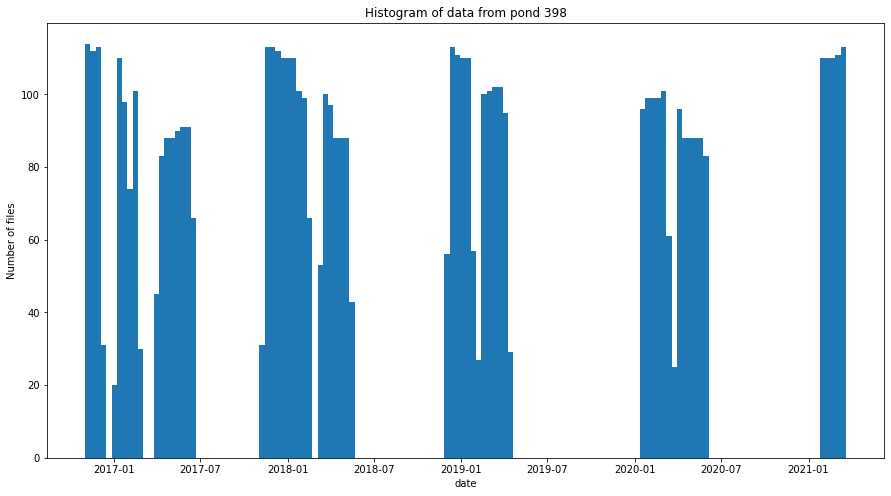

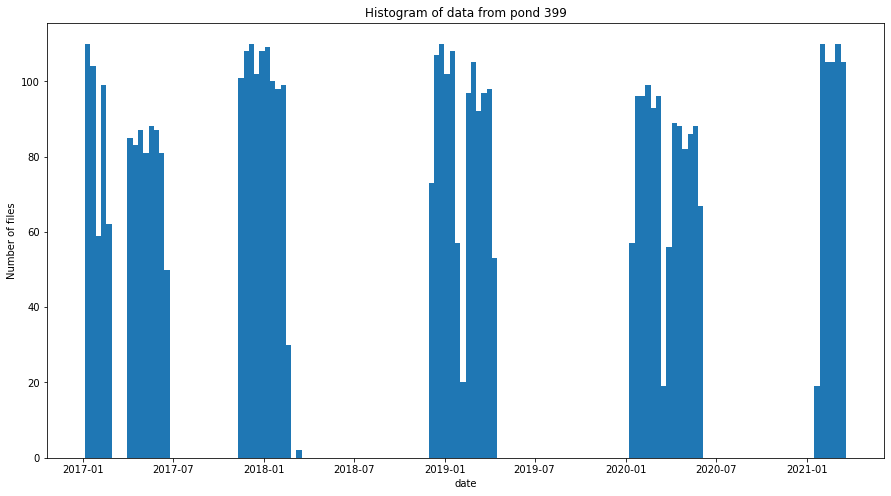

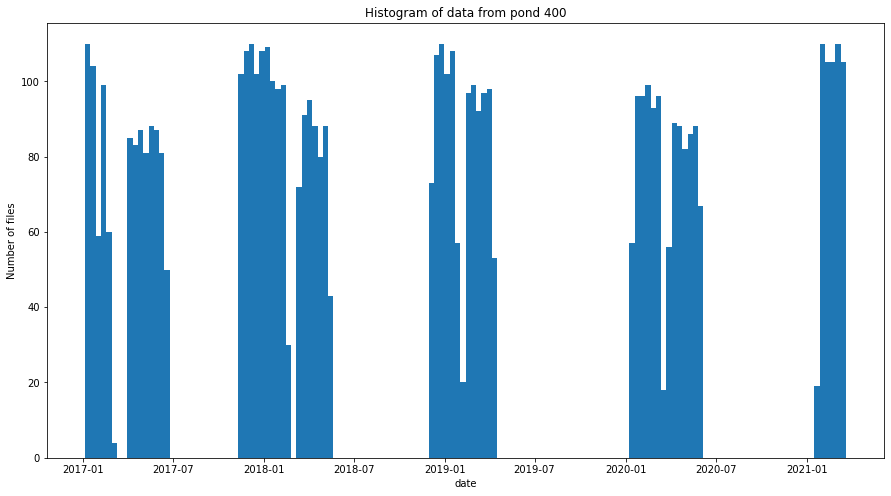

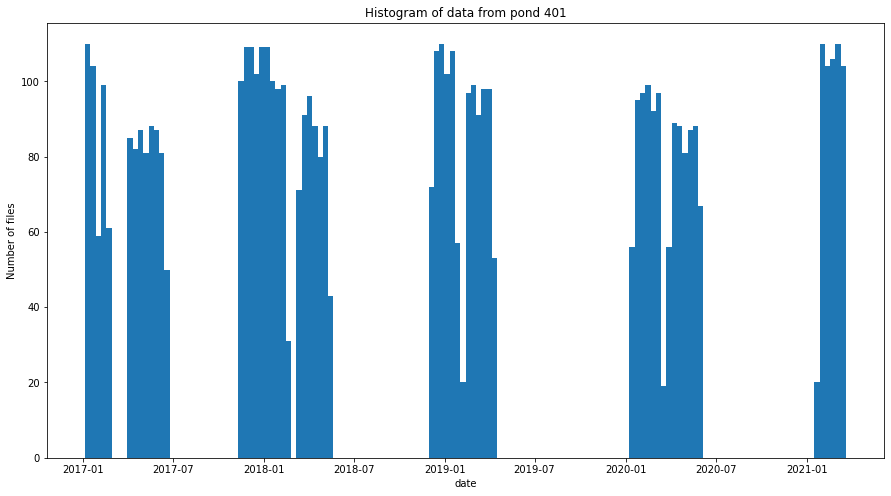

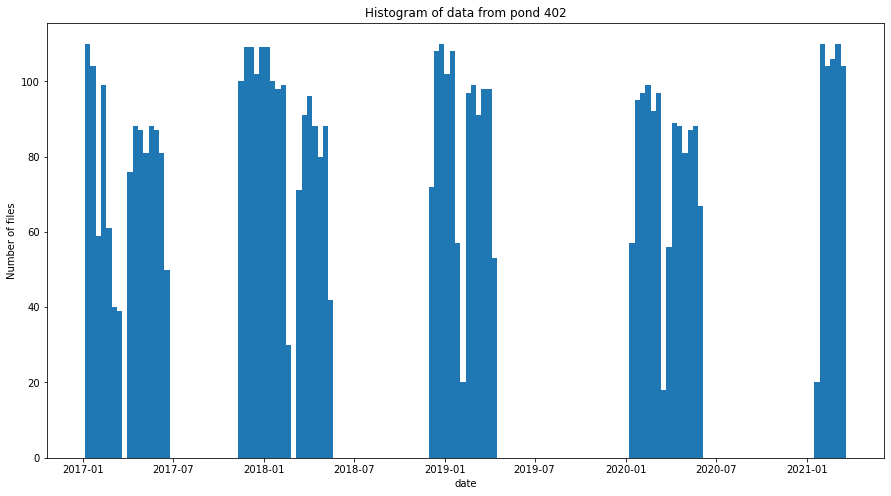

In [6]:
#pd.set_option('display.max_colwidth', -1) 
#rs_df[rs_df["pond"] == 398][rs_df["year"] == 2017]

#for yr in range(2017,2022):
#    plot_rs_flshe(pond_no = 401, year = yr)

for pond in range(398, 403): 
    plot_hist(pond_no = pond)


In [264]:
rs_df[rs_df["pond"] == 398][rs_df[rs_df["pond"] == 398]['score'] > 40]

,file_path,score,year,pond,time_stamp,date,Lcapito
1113,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180508_222300.wav,60.22,2018,398,232.0,2018-05-08 22:23:00,NaN
1114,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180511_012500.wav,57.53,2018,398,44.0,2018-05-11 01:25:00,NaN
1115,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180318_234700.wav,55.39,2018,398,138.0,2018-03-18 23:47:00,NaN
1116,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180121_190000.wav,52.94,2018,398,40.0,2018-01-21 19:00:00,NaN
1117,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180116_195500.wav,52.62,2018,398,6.0,2018-01-16 19:55:00,NaN
...,...,...,...,...,...,...,...
6581,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20170111_205100.wav,40.08,2017,398,174.0,2017-01-11 20:51:00,NaN
6582,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20161129_183100.wav,40.07,2017,398,284.0,2016-11-29 18:31:00,NaN
6583,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20170414_230600.wav,40.03,2017,398,182.0,2017-04-14 23:06:00,NaN
6584,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20171215_003300.wav,40.01,2017,398,44.0,2017-12-15 00:33:00,NaN
